In [1]:
W_list = [
    "2TGLXRTZ",
    "3ZH607HZ",
    "3ZH61Z0Z",
    "3ZH609ZZ",
    "2TGLYS7Z",
    "3ZH61PWZ",
    "3ZH5Z5XZ",
    "3ZH620SZ",
    "3ZH6200Z",
    "3ZH5X4UZ",
    "3ZH5LL0Z",
    "2TGLXTRZ"
]

R_list = [
    "2GJ5BMAD",
    "2TGLU8RZ"
]

V_list = [
    "2GG02VGL",
    "2GH2KP7S",
    "2GHR65SS",
    "2GJ2XK9S",
    "2GJ3R6SD",
    "2GJ68Y3S",
    "2TGLJDWZ",
    "2GJ69HJS",
    "3ZH4NYAZ",
    "ZGG0AABA",
]

In [2]:
from cnn_predictor import CNN_Predictor
from early_tdp import *
import time

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# model_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\models\best_sequencer2d_m.in1k_all_v1_noNorm.pt"
model_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\models\best_resnet18d_all_noNorm_kv1_fold3.pt"
# model_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\models\models_cuda\best_sequencer2d_s.in1k_all_noNorm_kv1_cuda_fold3.pt"
# model_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\code\tdp_production\production_models\best_sequencer2d_s.in1k_normal_inc_dec_v1_noNorm_cuda.pt"
predictor = CNN_Predictor(model_path=model_path)
model = predictor.load_model()
print(predictor.chpt.keys())
print(predictor.chpt["transform"])

dict_keys(['arch', 'state_dict', 'class_to_idx', 'transform'])
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


['0000' '6FPV']
not split ec


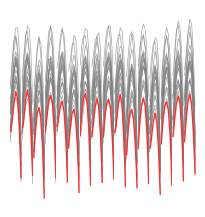

time1:  0.9078288078308105
time2:  0.3236699104309082
2GHYLKTW 11
{'class': ['low_tdp', 'normal_ID-OD', 'other_all'], 'confidence': [59.09, 16.8, 8.47]}
{'head': [11], 'TDP_level': ['normal'], 'TDP_change': ['no'], 'TDP_early': ['no']}


In [4]:
from PIL import Image
from plotTDP import *

# csv_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\VL_TDP\6FPW\TDP_6FPW.csv"
# csv_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\VL_TDP\6FPR\TDP_6FPR.csv"
# csv_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\VL_TDP\6FPV\TDP_6FPV_R_W.csv"
hddsn = "2GHYLKTW"
csv_path = f"C:/Users/1000303969\OneDrive - Western Digital/work/tdp classification/VL_TDP/6FPV_v2/TDP_{hddsn}.csv"

split_ec = False

df = pd.read_csv(csv_path)
ec = df["pfcode"].unique()
print(ec)

if split_ec:
    if ("6FPR" in ec) and ("6FPV" not in ec):
        hddsn_list = R_list
    elif "6FPW" in ec:
        hddsn_list = W_list
    else:
        hddsn_list = V_list
else:
    print("not split ec")
    hddsn_list = df["hddsn"].unique()

for hddsn in hddsn_list:
    df_filter = df[df["hddsn"] == hddsn]
    failure_head_list = get_bad_head(df=df_filter)
    n_fh = len(failure_head_list)
    for fh_i in range(n_fh):
        st1 = time.time()
        tdp = TDP(df=df_filter, bad_head_list=[failure_head_list[fh_i]])
        fig = tdp.display()
        # plt.savefig(f"{hddsn}_{failure_head_list[0]}.png", dpi=300, bbox_inches='tight', pad_inches=0)
        plt.show(fig)
        result = predictor.predict(model, fig, is_path=False)
        end1 = time.time()
        print("time1: ", end1 - st1)
        st2 = time.time()
        obj = EARLY_TDP(df=df_filter, bad_head_list=[failure_head_list[fh_i]])
        symptom = obj.run()
        end2 = time.time()
        print("time2: ", end2 - st2)
        print(hddsn, failure_head_list[fh_i])
        print(result)
        print(symptom)  
        print("==================================================")

# hddsn_filter = "3ZH5Z5XZ"
# df_filter = df[df["hddsn"] == hddsn_filter]
# failure_head_list = get_bad_head(df=df_filter)
# print(failure_head_list)
# tdp = TDP(df=df_filter, bad_head_list=failure_head_list)
# fig = tdp.display()
# plt.show()

# obj = EARLY_TDP(df=df_filter, bad_head_list=failure_head_list)
# symptom = obj.run()
# print(symptom)

# result = predictor.predict(model, fig)
# fig2 = predictor.convert_to_arr(fig)

# result = predictor.predict(model, fig, is_path=False)
# print(result)

In [46]:
import shutil
pred_csv_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\data\TDTM\TDFF\result_2.csv"
image_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\data\TDTM\TDFF_IMAGES"
output_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\data\TDTM\TDFF_GROUP"

df = pd.read_csv(pred_csv_path)
print(df.columns)

for idx in range(len(df)):
    pic_name = f"{df['serial'][idx]}_{df['fh'][idx]}.png"
    pic_path = os.path.join(image_path, pic_name)
    pred = df["predict"][idx]
    pred_post_proc = word_post_process_invert(pred)
    os.makedirs(os.path.join(output_path, pred_post_proc), exist_ok=True)
    shutil.copy(pic_path, os.path.join(output_path, pred_post_proc, pic_name))
print("done")

Index(['serial', 'fh', 'predict', 'flag', 'confidence'], dtype='object')
done


In [18]:
def word_post_process_invert(word):
    if "Other" in word:
        return "other"
    elif "Airmix/Helium Leak" in word:
        return "airmix_helium_leak"
    elif "normal TDP and ID<OD" in word:
        return "normal_ID-OD"
    elif "normal TDP and OD<ID" in word:
        return "normal_OD-ID"
    elif "high TDP and OD-ID" in word:
        return "high_od+id"
    elif "Delta OD-ID" in word:
        return "delta_od_id"
    elif "High TDP" in word:
        return "high_tdp"
    elif "Low TDP" in word:
        return "low_tdp"
    elif "High TDP and Recovery" in word:
        return "high_recovery"
    elif "Low TDP and Recovery" in word:
        return "low_recovery"
    elif "High TDP and Decrease" in word:
        return "high_decrease"
    elif "Low TDP and Increase" in word:
        return "low_increase"
    elif "Normal TDP and Increase" in word:
        return "normal_increase"
    elif "Normal TDP and Decrease" in word:
        return "normal_decrease"
    elif "Reverse TDP" in word:
        return "revert"
    elif "Early TDP" in word:
        return "early_tdp"
    else:
        return "other"

In [34]:
%%time
squares = [i**2 for i in range(1_000_000)]

CPU times: total: 344 ms
Wall time: 450 ms


In [36]:
squares[1]

1

In [37]:
%%time
square = []
for i in range(1_000_000):
    square.append(i**2)

CPU times: total: 484 ms
Wall time: 562 ms
